In [1]:
!pip install gensim datasets sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 83.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import gensim.downloader as api
from sklearn.decomposition import TruncatedSVD
from scipy.stats import pearsonr, spearmanr
from sentence_transformers import SentenceTransformer, util


/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Python(22503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
ds = load_dataset("mteb/stsbenchmark-sts")

train_df = pd.DataFrame(ds["train"])
dev_df = pd.DataFrame(ds["validation"])
test_df = pd.DataFrame(ds["test"])

train_df.head()

Python(22554) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,0001,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,0004,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,0005,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,0006,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,0009,4.25,A man is playing the cello.,A man seated is playing the cello.


In [4]:
print("Train:", len(train_df))
print("Dev:", len(dev_df))
print("Test:", len(test_df))

train_df.describe(include="all")

Train: 5749
Dev: 1500
Test: 1379


,split,genre,dataset,year,sid,score,sentence1,sentence2
count,5749,5749,5749,5749,5749,5749.000000,5749,5749
unique,1,3,6,6,1244,NaN,5436,5419
top,train,main-news,headlines,2014,0217,NaN,A man is playing a guitar.,A man is playing a guitar.
freq,5749,3299,1999,1856,11,NaN,16,23
mean,NaN,NaN,NaN,NaN,NaN,2.700999,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,1.464398,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.500000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,3.800000,NaN,NaN


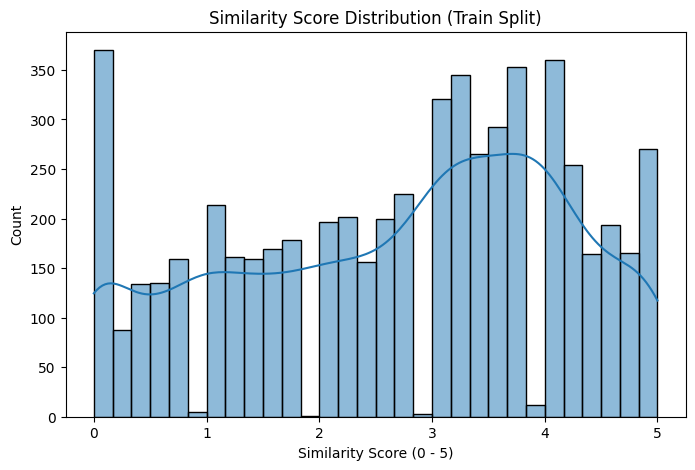

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(train_df["score"], bins=30, kde=True)
plt.title("Similarity Score Distribution (Train Split)")
plt.xlabel("Similarity Score (0 - 5)")
plt.ylabel("Count")
plt.show()

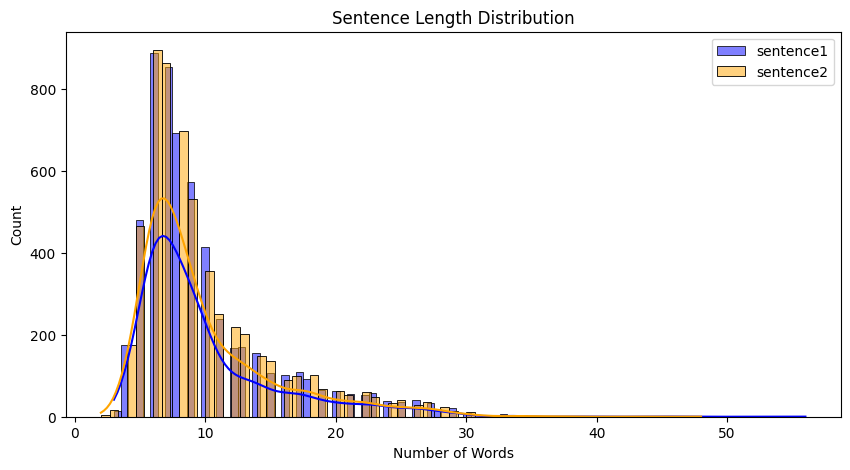

In [6]:
train_df["len1"] = train_df["sentence1"].str.split().apply(len)
train_df["len2"] = train_df["sentence2"].str.split().apply(len)

plt.figure(figsize=(10,5))
sns.histplot(train_df["len1"], label="sentence1", color="blue", kde=True)
sns.histplot(train_df["len2"], label="sentence2", color="orange", kde=True)
plt.legend()
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.show()

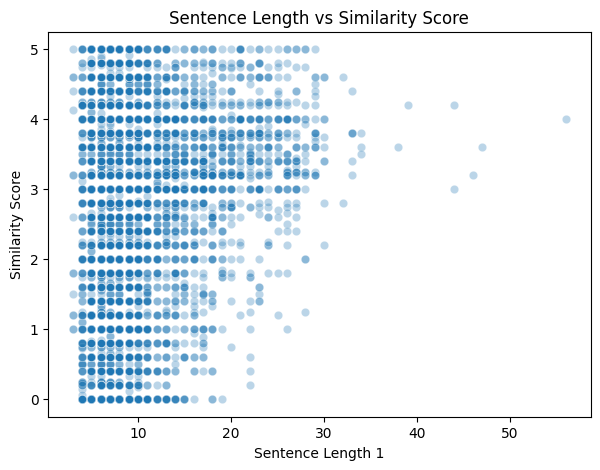

In [7]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=train_df["len1"], y=train_df["score"], alpha=0.3)
plt.title("Sentence Length vs Similarity Score")
plt.xlabel("Sentence Length 1")
plt.ylabel("Similarity Score")
plt.show()

In [6]:
sample = train_df.sample(2000, random_state=42).reset_index(drop=True)

In [ ]:
tfidf = TfidfVectorizer(stop_words="english", max_features=50000)
tfidf_matrix = tfidf.fit_transform(
    pd.concat([sample["sentence1"], sample["sentence2"]])
)

svd = TruncatedSVD(n_components=300, random_state=42)
lsa_matrix = svd.fit_transform(tfidf_matrix)

s1_emb = lsa_matrix[:len(sample)]
s2_emb = lsa_matrix[len(sample):]

lsa_sim = cosine_similarity(s1_emb, s2_emb).diagonal()

human = sample["score"].values / 5.0

pearson_lsa = pearsonr(lsa_sim, human)[0]
spearman_lsa = spearmanr(lsa_sim, human)[0]

print("LSA Pearson :", pearson_lsa)
print("LSA Spearman:", spearman_lsa)

LSA Pearson : 0.6382665802423071
LSA Spearman: 0.5841790905952737


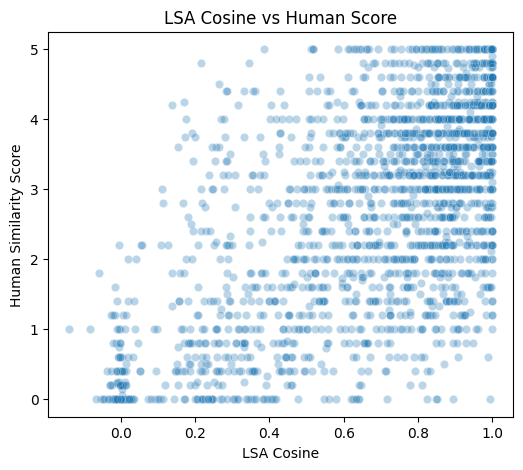

In [23]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=lsa_sim, y=sample["score"], alpha=0.3)
plt.title("LSA Cosine vs Human Score")
plt.xlabel("LSA Cosine")
plt.ylabel("Human Similarity Score")
plt.show()

In [3]:
w2v = api.load("word2vec-google-news-300")

In [4]:
def sentence_vector(sentence):
    words = sentence.split()
    word_vectors = [w2v[word] for word in words if word in w2v]
    if len(word_vectors) == 0:
        return np.zeros(w2v.vector_size)
    return np.mean(word_vectors, axis=0)

In [7]:
sample_w2v = sample.copy()

sample_w2v["vec1"] = sample_w2v["sentence1"].apply(sentence_vector)
sample_w2v["vec2"] = sample_w2v["sentence2"].apply(sentence_vector)

w2v_sim = np.array([
    cosine_similarity([v1], [v2])[0][0]
    for v1, v2 in zip(sample_w2v["vec1"], sample_w2v["vec2"])
])

In [ ]:
print("W2V Pearson:", pearsonr(w2v_sim, sample_w2v["score"])[0])
print("W2V Spearman:",  spearmanr(w2v_sim, sample_w2v["score"])[0])

WMD Pearson: 0.4699070333284097
WMD Spearman: 0.44758022394340263


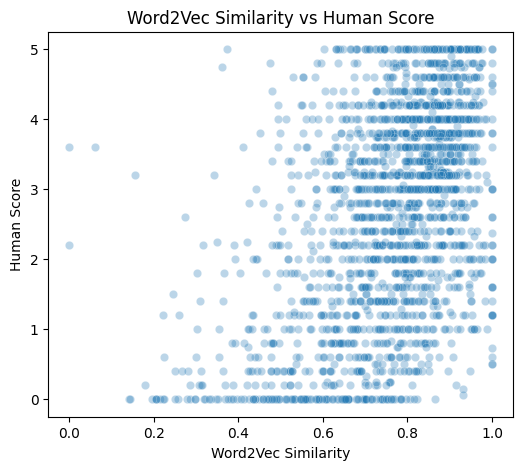

In [14]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=w2v_sim, y=sample["score"], alpha=0.3)
plt.title("Word2Vec Similarity vs Human Score")
plt.xlabel("Word2Vec Similarity")
plt.ylabel("Human Score")
plt.show()

In [15]:
def evaluate_contextual_model(model_name, model_path, df):
    print(f"Evaluating model: {model_name}")

    model = SentenceTransformer(model_path)

    emb1 = model.encode(df["sentence1"].tolist(), convert_to_tensor=True)
    emb2 = model.encode(df["sentence2"].tolist(), convert_to_tensor=True)

    sim = util.cos_sim(emb1, emb2).diagonal().cpu().numpy()

    pearson = pearsonr(sim, df["score"])[0]
    spearman = spearmanr(sim, df["score"])[0]

    return {
        "model": model_name,
        "pearson": pearson,
        "spearman": spearman,
        "similarity": sim
    }


def plot_similarity_scatter(similarity, human_score, model_name, alpha=0.3):
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=similarity, y=human_score, alpha=alpha)
    plt.title(f"{model_name} Similarity vs Human Score")
    plt.xlabel(f"{model_name} Predicted Similarity")
    plt.ylabel("Human Score")
    plt.show()

In [16]:
sample = sample.reset_index(drop=True)

contextual_models = {
    "MiniLM-L6": "sentence-transformers/all-MiniLM-L6-v2",
    "MiniLM-L12": "sentence-transformers/all-MiniLM-L12-v2",
    "MPNet": "sentence-transformers/all-mpnet-base-v2",
    "E5-base": "intfloat/e5-base",
    "E5-large": "intfloat/e5-large",
    "Instructor-large": "hkunlp/instructor-large",
}

Evaluating model: MiniLM-L6


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

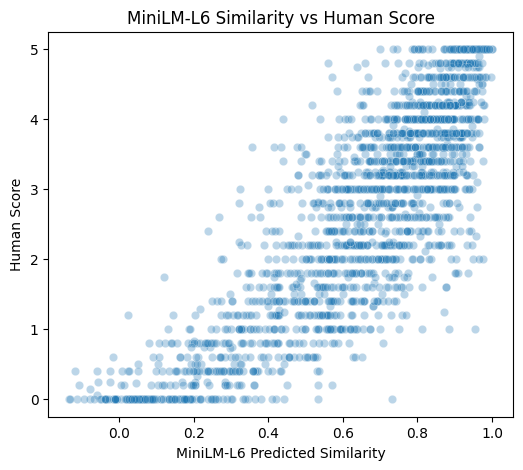

Evaluating model: MiniLM-L12


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

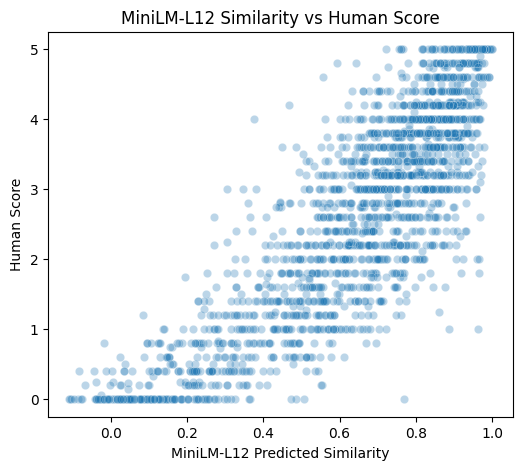

Evaluating model: MPNet


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

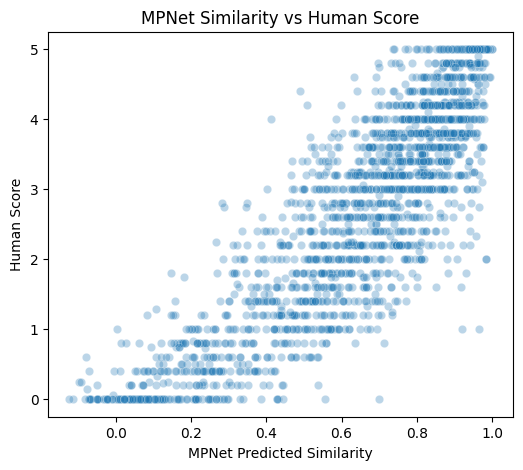

Evaluating model: E5-base


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

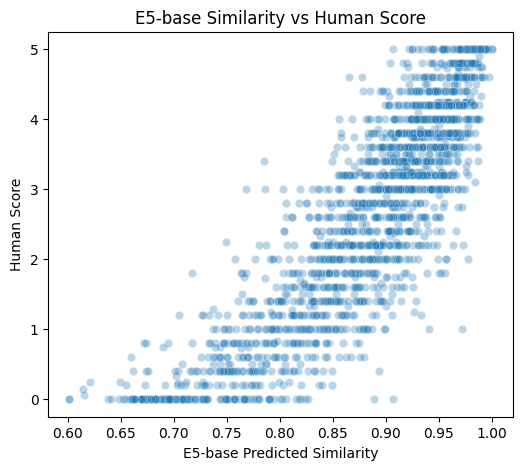

Evaluating model: E5-large


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

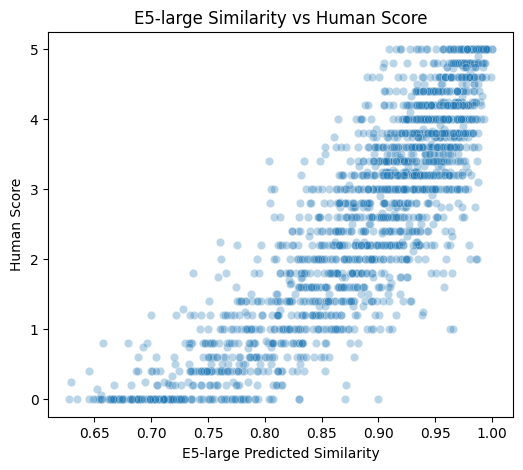

Evaluating model: Instructor-large


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

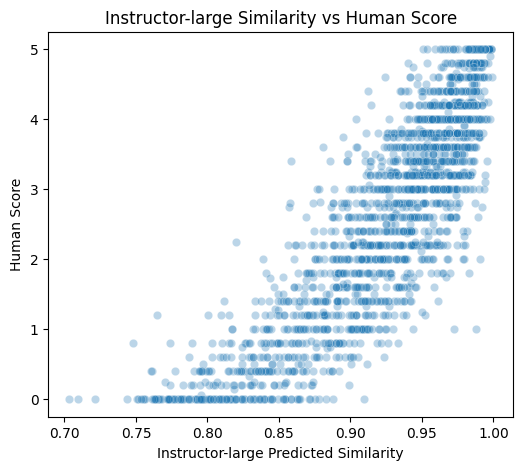

,model,pearson,spearman
0,MiniLM-L6,0.841562,0.821033
1,MiniLM-L12,0.853022,0.835204
2,MPNet,0.862092,0.848778
3,E5-base,0.867719,0.866669
4,E5-large,0.872536,0.866279
5,Instructor-large,0.864224,0.864065


In [17]:
results = []

for name, path in contextual_models.items():
    res = evaluate_contextual_model(name, path, sample)
    plot_similarity_scatter(res["similarity"], sample["score"], name)
    results.append(res)


df_contextual = pd.DataFrame([
    {k: v for k, v in r.items() if k != "similarity"}
    for r in results
])
df_contextual

In [24]:
comparison = pd.DataFrame({
    "model": ["lsa", "word2vec"],
    "pearson": [
        pearson_lsa,
        pearsonr(w2v_sim, sample_w2v["score"])[0]
    ],
    "spearman": [
        spearman_lsa,
        spearmanr(w2v_sim, sample_w2v["score"])[0]
    ],
})

final_comparison = pd.concat([comparison, df_contextual], ignore_index=True)
final_comparison = final_comparison.sort_values(by="pearson", ascending=False)

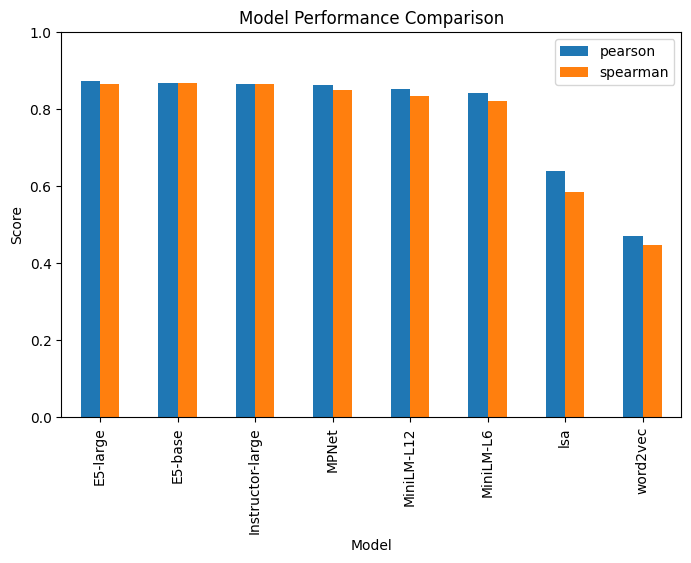

In [25]:
final_comparison.plot(x="model", y=["pearson", "spearman"], kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend()
plt.show()